In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
    
import markdown
from lxml import etree
import re
from urllib.parse import urlsplit
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryanmurray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ryanmurray/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
downs = pd.read_csv('results-20180502-121033.csv')

In [3]:
ups = pd.read_csv('2014_ups.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ups['dnv'] = 0
downs['dnv'] = 1

In [245]:
comments = pd.concat([ups,downs])
comments = comments.reset_index()
drop_cols = ['index','score_hidden','name','downs','subreddit_id','subreddit','controversiality','gilded','ups','distinguished','removal_reason']

comments = comments.drop(drop_cols,axis=1)

comments['body'] = comments['body'].apply(lambda x: drop_newlines(x))
comments['created_utc'] = pd.to_datetime(comments['created_utc'],unit='s')
comments['retrieved_on'] = pd.to_datetime(comments['retrieved_on'],unit='s')

comments['age_retrieved'] = comments['retrieved_on'] - comments['created_utc']

In [10]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words if len(word)<20)/len(words))

def extract_md_link(post):
    doc = etree.fromstring(markdown.markdown(post))
    links = []
    for link in doc.xpath('//a'):
        links.append(link.get('href'))    
    return ' '.join(links)

def drop_newlines(post):
    return ' '.join(post.split('\n'))

In [7]:
def get_link(post):

    myString_list = [item for item in post.split(" ")]
    url_list = []
    for item in myString_list:
        try:
            a = re.search("(?P<url>https?://[^\s]+)", item) or re.search("(?P<url>www[^\s]+)", url)
            a = a.group('url')
            b = '.'.join(urlsplit(a).hostname.split('.')[-2:])
            
            url_list.append(b)
        except:
            pass

    return ' '.join(url_list)

In [72]:
def replace_md_links(body):
    ans = re.findall(r"\[(.*?)\]\((.*?)\)",body)
    text = ' '.join([a[0] for a in ans])
    ret = re.sub(r"\[(.*?)\]\((.*?)\)",'',body)
    new_body = ret + ' ' + text
    return ' '.join([x for x in new_body.split(' ') if len(x) < 20])
    


In [171]:
def has_flair(flair):
    if type(flair) == float:
        return 0
    else: return 1

In [230]:
def filter_deleted(author):
    if author == '[deleted]': return 1
    else: return 0

In [237]:
def remove_deleted(author):
    if author == '[deleted]': return None
    else: return author

In [246]:
comments['author_deleted'] = comments['author'].apply(filter_deleted)
comments['author_fix'] = comments['author'].apply(remove_deleted)
comments['author_counts'] = comments.groupby(['author_fix'])['body'].transform('count').fillna(0)


In [172]:
comments['has_flair'] = comments['author_flair_text'].apply(has_flair)

In [11]:
comments['word_count'] = comments['body'].apply(lambda x: len(str(x).split(' ')))
comments['avg_word'] = comments['body'].apply(lambda x: avg_word(x))

comments['links'] = comments['body'].apply(lambda x: get_link(x))

In [20]:
stop = stopwords.words('english')

comments['stopwords'] = comments['body'].apply(lambda x: len([x for x in x.split() if x in stop]))

In [22]:
comments['numerics'] = comments['body'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

In [28]:
comments['upper'] = comments['body'].apply(lambda x: len([x for x in x.split() if x.isupper() and len(x)>1]))


In [96]:
comments['body_clean'] = comments['body'].apply(lambda x: " ".join(x.lower() for x in x.split()))
comments['body_clean'] = comments['body_clean'].apply(replace_md_links)
comments['body_clean'] = comments['body_clean'].str.replace('[^\w\s]','')

comments['body_clean'] = comments['body_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))



In [97]:
freq = pd.Series(' '.join(comments['body_clean']).split()).value_counts()[:20]

freq = list(freq.index)
comments['body_clean'] = comments['body_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [98]:
lowfreq = pd.Series(' '.join(comments['body_clean']).split()).value_counts()
only_one = lowfreq[lowfreq == 1]

In [99]:
comments['body_clean']=comments['body_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in only_one))

In [109]:
def spell_correct():
    #This will take about 3 hours!!!!!
    comments['body_spell_corrected'] = comments['body_clean'][:100].apply(lambda x: str(TextBlob(x).correct()))


In [108]:
comments.shape

(37867, 21)

In [110]:
len(pd.Series(' '.join(comments['body_clean']).split()).value_counts())

22718

In [113]:
from textblob import Word
comments['body_clean']=comments['body_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [117]:
comments['sentiment'] = comments['body_clean'].apply(lambda x: TextBlob(x).sentiment[0])


In [125]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=3000, lowercase=True, ngram_range=(1,3),analyzer = "word")
train_bow = bow.fit_transform(comments['body_clean'])


(37867, 3000)

In [216]:
X = pd.DataFrame(train_bow.toarray())

In [134]:
y = comments['dnv']

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 5)

In [137]:
from sklearn.linear_model import LogisticRegression

In [140]:
lr = LogisticRegression()

In [141]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [145]:
y_preds = lr.predict_proba(X_test)[:,1]

In [146]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Text(0,0.5,'TPR')

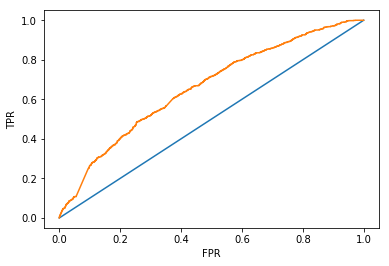

In [147]:
fpr, tpr,thresh = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [211]:
comments.columns

Index(['body', 'archived', 'author', 'author_flair_text', 'created_utc',
       'link_id', 'parent_id', 'score', 'retrieved_on', 'id',
       'author_flair_css_class', 'dnv', 'age_retrieved', 'word_count',
       'avg_word', 'links', 'stopwords', 'numerics', 'upper', 'body_lower',
       'body_clean', 'sentiment', 'has_flair', 'author_counts'],
      dtype='object')

In [212]:
good_cols = comments[['word_count','avg_word','stopwords','numerics','upper','sentiment','has_flair','author_counts']]

In [215]:
bow = CountVectorizer(max_features=100, lowercase=True, ngram_range=(1,3),analyzer = "word")
link_bow = bow.fit_transform(comments['links'])
link_counts = pd.DataFrame(link_bow.toarray())

In [232]:
comments['author_deleted'].value_counts()

0    33139
1     4728
Name: author_deleted, dtype: int64

In [251]:
full_X = X.merge(good_cols, how='outer', left_index=True, right_index=True).merge(link_counts,how='outer', left_index=True, right_index=True)

In [252]:
full_X.shape

(37867, 3108)

Text(0,0.5,'TPR')

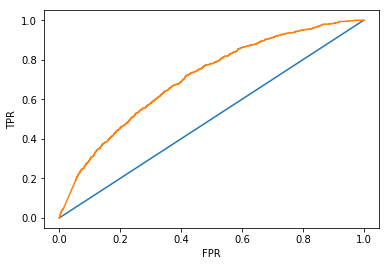

In [253]:
lr = LogisticRegression()

X_train,X_test,y_train,y_test = train_test_split(full_X,y,test_size = 0.2,random_state = 5)

lr.fit(X_train,y_train)
y_preds = lr.predict_proba(X_test)[:,1]

fpr, tpr,thresh = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')